In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
# to play the audio files
from IPython.display import Audio

In [2]:
lang_audio= "/kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset"

In [3]:
f=0
for dirname, folder, filenames in os.walk('/kaggle/input'):
        f+= len(filenames)
print("Total samples: ",f )
print("Avg samples per language: ",f/10 )

Total samples:  256833
Avg samples per language:  25683.3


In [5]:
file_language = os.listdir(lang_audio)
file_paths = []
dir_paths=[]
for dirs in data_directory_list:
    language = os.listdir(lang_audio +"/"+ dirs)
    dir_paths.append(lang_audio +"/"+ dirs)
    for file in language:
        file_paths.append(lang_audio + dirs + '/' + file)

languages_df = pd.DataFrame(file_language, columns=['Language'])

path_df = pd.DataFrame(dir_paths, columns=['Path'])
dataset_df = pd.concat([languages_df, path_df], axis=1)


In [6]:
dataset_df

,Language,Path
0,Punjabi,/kaggle/input/audio-dataset-with-10-indian-lan...
1,Tamil,/kaggle/input/audio-dataset-with-10-indian-lan...
2,Hindi,/kaggle/input/audio-dataset-with-10-indian-lan...
3,Bengali,/kaggle/input/audio-dataset-with-10-indian-lan...
4,Telugu,/kaggle/input/audio-dataset-with-10-indian-lan...
5,Kannada,/kaggle/input/audio-dataset-with-10-indian-lan...
6,Gujarati,/kaggle/input/audio-dataset-with-10-indian-lan...
7,Urdu,/kaggle/input/audio-dataset-with-10-indian-lan...
8,Marathi,/kaggle/input/audio-dataset-with-10-indian-lan...
9,Malayalam,/kaggle/input/audio-dataset-with-10-indian-lan...


In [7]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} language'.format(e), size=15)
    plt.plot(data)    
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} language'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

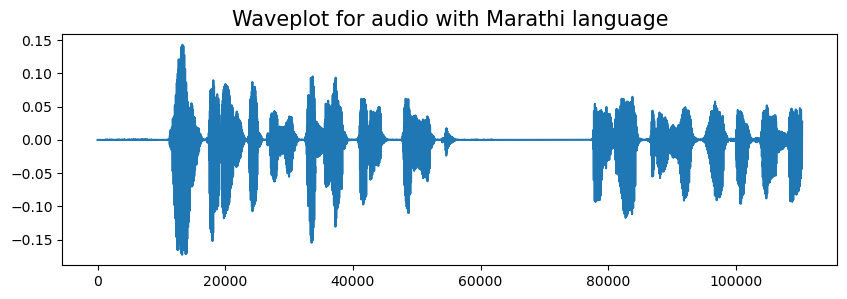

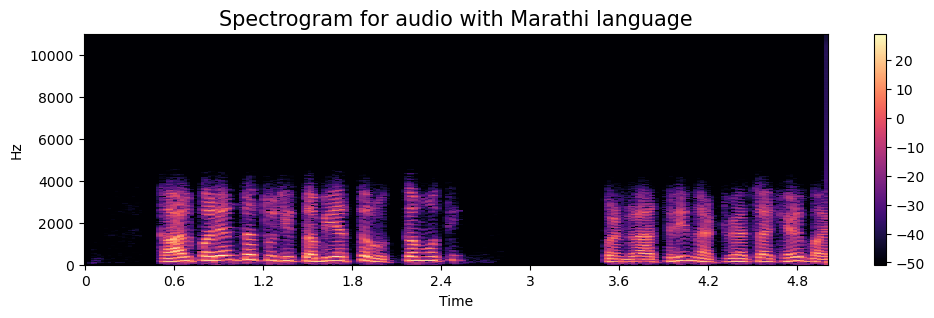

In [8]:
language='Marathi'

path = np.array(dataset_df.Path[dataset_df.Language==language])[0]
path= path +'/'+os.listdir(path)[4]

data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, language)
create_spectrogram(data, sampling_rate, language)
Audio(path)